<div style="background-color:#D2DCFA; padding:10px;">
    
# Описание задачи.
    
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
    

Нам необходимо построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
    
 > качество предсказания;
    
 > время обучения модели;
    
 > время предсказания модели.
    
    
Чтобы усилить исследование, не будем ограничиваться градиентным бустингом. Попробуем более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
    
Будем использовать следующие модели:
    
 > Линейная регрессия - будет базовой моделью
    
 > Градиентный бустинг LightGBM
    
 > Градиентный бустинг CatBoost
    
    
В качестве метрики выступит **`RMSE`**. Максимальное допустимое значение метрики - **`2500`**.

<div style="background-color:#D2DCFA; padding:10px;">
    
# Описание данных

Признаки: 
 - **DateCrawled** — дата скачивания анкеты из базы
    
 - **VehicleType** — тип автомобильного кузова
 - **RegistrationYear** — год регистрации автомобиля
 - **Gearbox** — тип коробки передач
 - **Power** — мощность (л. с.)
 - **Model** — модель автомобиля
 - **Kilometer** — пробег (км)
 - **RegistrationMonth** — месяц регистрации автомобиля
 - **FuelType** — тип топлива
 - **Brand** — марка автомобиля
 - **Repaired** — была машина в ремонте или нет
 - **DateCreated** — дата создания анкеты
 - **NumberOfPictures** — количество фотографий автомобиля
 - **PostalCode** — почтовый индекс владельца анкеты (пользователя)
 - **LastSeen** — дата последней активности пользователя
    
Целевой признак **`Price`**

Загрузим необходимые библиотеки

In [1]:
!pip install phik

In [2]:
!pip install -U scikit-learn

In [3]:
!pip install lightgbm

In [4]:
!pip install catboost

Импортируем библиотеки

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor

import lightgbm as lgb

from phik import phik_matrix
from phik.report import plot_correlation_matrix

import time 

import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid') 
plt.rcParams["figure.figsize"] = (12, 6)

In [6]:
RANDOM_STATE = 42

## Шаг 1. Загрузка и предобработка данных

In [7]:
try:
    df = pd.read_csv(r'C:\Users\ilyal\OneDrive\Рабочий стол\Портфолио\practicum_projects\autos_price_10\autos_price_10.csv')
    
except:
    df = pd.read_csv(r'/datasets/autos.csv')
    
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
352818,2016-04-01 22:50:00,1400,sedan,1994,manual,60,golf,125000,1,petrol,volkswagen,no,2016-04-01 00:00:00,0,67278,2016-04-05 21:45:01
326697,2016-03-12 01:32:36,4400,convertible,2006,manual,140,3_reihe,150000,8,petrol,peugeot,no,2016-03-12 00:00:00,0,55131,2016-04-07 05:16:08
320195,2016-03-06 01:43:32,5500,NaN,2017,manual,140,golf,150000,10,gasoline,volkswagen,no,2016-01-29 00:00:00,0,14943,2016-03-28 14:45:05
120584,2016-03-27 18:48:59,9500,sedan,2007,manual,160,a3,60000,11,petrol,audi,no,2016-03-27 00:00:00,0,89233,2016-04-05 15:45:49
36266,2016-03-24 19:54:29,500,sedan,1998,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,38259,2016-03-26 05:17:24


Для удобства сразу приведем все названия столбцов к нижнему регистру 

In [8]:
df.columns = [column.lower() for column in df.columns]

Выведем основную информацию о датафрейме

In [9]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

None

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Можно сразу выделить несколько проблем:

- пропуски в столбцах `vehicletype`, `fueltype`, `model` и `repaired`

- в столбцах `registrationyear` и `power` есть заметные выбросы

- столбцы `numberofpictures`, `datecreated`, `registrationmonth`, `postalcode` и `lastseen` можно удалить. Число картинок везде равно нулю, год и месяц есть в отдельных столбцах, почтовый индекс не несет в себе смысловую нагрузку, а дата последней активности пользователя неинформативна.

- вместо столбца `datecrawled` оставим только год выгрузки данных для установки границы, а после удалим его.

In [10]:
df = df.drop(['numberofpictures', 'datecreated', 'lastseen', 'postalcode', 'registrationmonth'], axis=1)

Заполним пропуски.

Пропусков в датафрейме достаточно много и все они в в столбцах типа object. Чтобы не терять данные установим заглушку в виде строки **'unknown'**

In [11]:
df.fillna('unknown', inplace=True)

Переведем столбец с датой выгрузки анкеты из базы, чтобы в дальнейшем заменить выбросы в данных.

In [12]:
df['datecrawled'] = pd.to_datetime(df['datecrawled'])
df['datecrawled'] = df['datecrawled'].dt.year

## Шаг 2. Исследовательский анализ данных.

Для начала построим "ящик с усами" для числовых столбцов.

In [13]:
box_cols = ['price', 'registrationyear', 'power', 'kilometer']

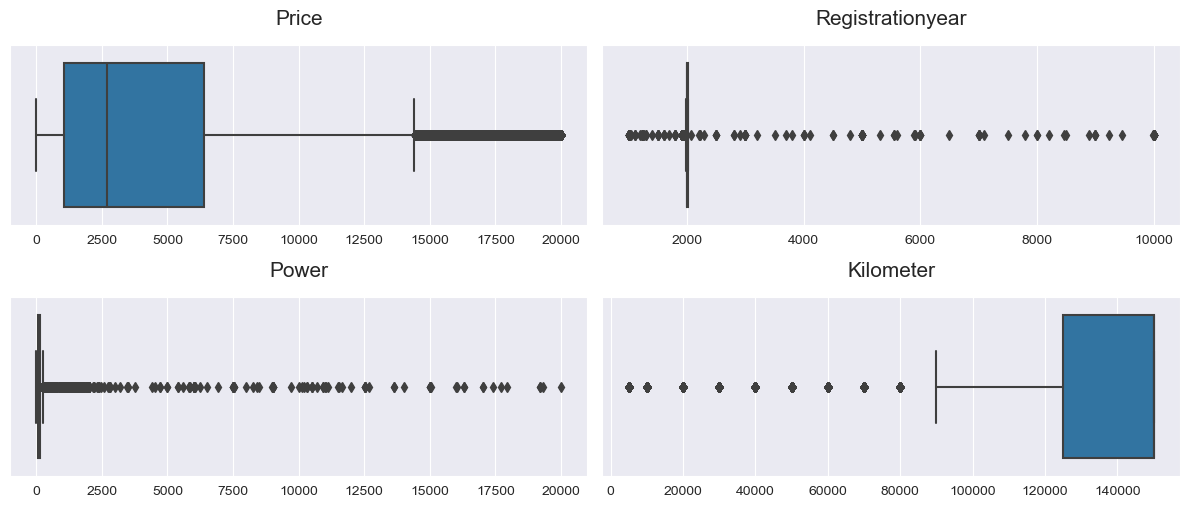

In [14]:
plt.figure(figsize=(12, 10))

# Цикл для построения графиков
for i, col in enumerate(box_cols, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=col, data=df)
    plt.title(col.capitalize(), fontsize=15, pad=15)
    plt.xlabel('')
    
plt.tight_layout()
plt.show()

Посмотрим на гистограмму по лошадиным силам.

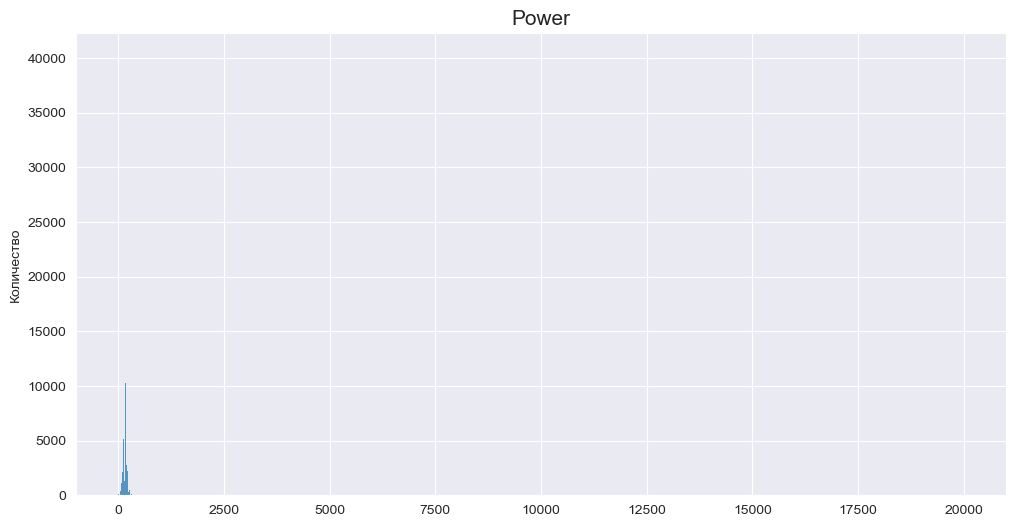

In [15]:
sns.histplot(data=df, x=df['power'])
plt.title('Power', fontsize=15)
plt.xlabel('')
plt.ylabel('Количество')

plt.show()

Лучшим значением для максимума будет 500 лошадиных сил

В столбцах power и registrationyear много выбросов. 
Для столбца `registrationyear` оставим года в диапазоне 1990 - 2016, всё остальное будем считать выбросами и заменим на значение года выгрузки данных из базы соответствующей строки.
Для столбца `power` установим диапазон 50-500 лошадиных сил.
В столбце `price` оставим машины, со стоимостью больше 750 евро.

In [16]:
df.loc[df['registrationyear'] > df['datecrawled'].max(), 'registrationyear'] = df['datecrawled']

In [17]:
df = df[df['registrationyear'] >= 1990]

Удалим столбец с датой выгрузки данных из базы. Она не несет в себе смысловой нагрузки.

In [18]:
df = df.drop('datecrawled', axis=1)

In [19]:
df = df[(df['power'] >= 50) & (df['power'] <= 500)]

In [20]:
df = df[df['price'] > 750]

Теперь построим ящики заново

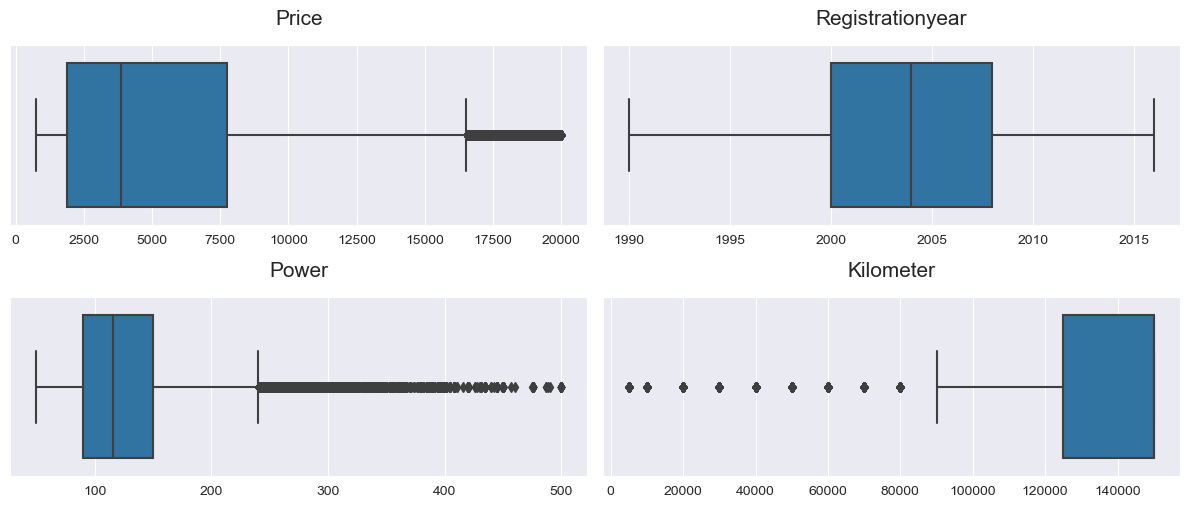

In [21]:
plt.figure(figsize=(12, 10))

# Цикл для построения графиков
for i, col in enumerate(box_cols, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=col, data=df)
    plt.title(col.capitalize(), fontsize=15, pad=15)
    plt.xlabel('')
    
plt.tight_layout()
plt.show()

Вывод по ящикам с усами:

- в столбце `registrationyear` был оставлен диапазон значений от 1990 - 2016 года, значения выше 2016 года были заполнены соответствуцющим значением из столбца `datecrawled`

- в столбце `power` был оставлен диапазон значений от 50 - 1000 лошадиных сил.

Теперь построим гистограммы.

In [22]:
hist_cols = ['price', 'power', 'kilometer', 'registrationyear']

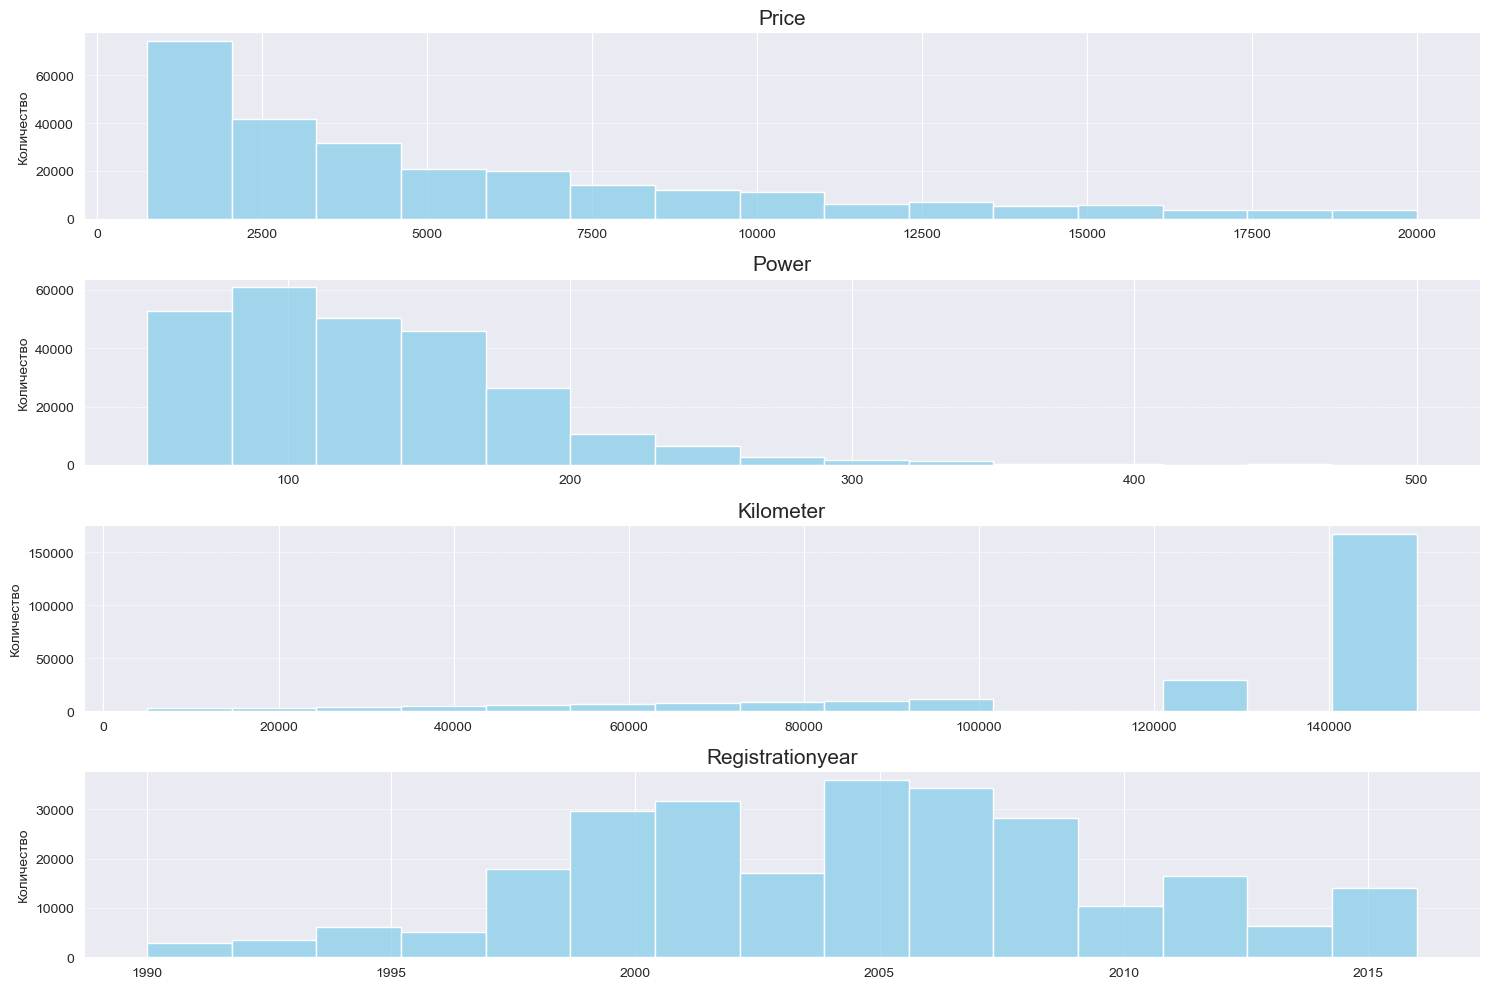

In [23]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(hist_cols, 1):
    plt.subplot(4, 1, i) 
    sns.histplot(data=df, x=col, color='skyblue', bins=15)
    plt.title(col.capitalize(), fontsize=15)
    plt.xlabel('')
    plt.ylabel('Количество')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    
plt.tight_layout()
plt.show()

Вывод по гистограммам:

- распределение цены скошено вправо, выбросов нет

- распределение лошадиных сил так же скошено вправо

- распределение пробега скошено влево. Большая часть значений сгруппированы после 140 тыс.км.

- распределение года регистрации автомобиля распределено нормально, большинство значений в диапазоне 1997-2010

Построение диаграмм накопления.

In [24]:
bar_cols = ['gearbox', 'vehicletype', 'fueltype', 'repaired']

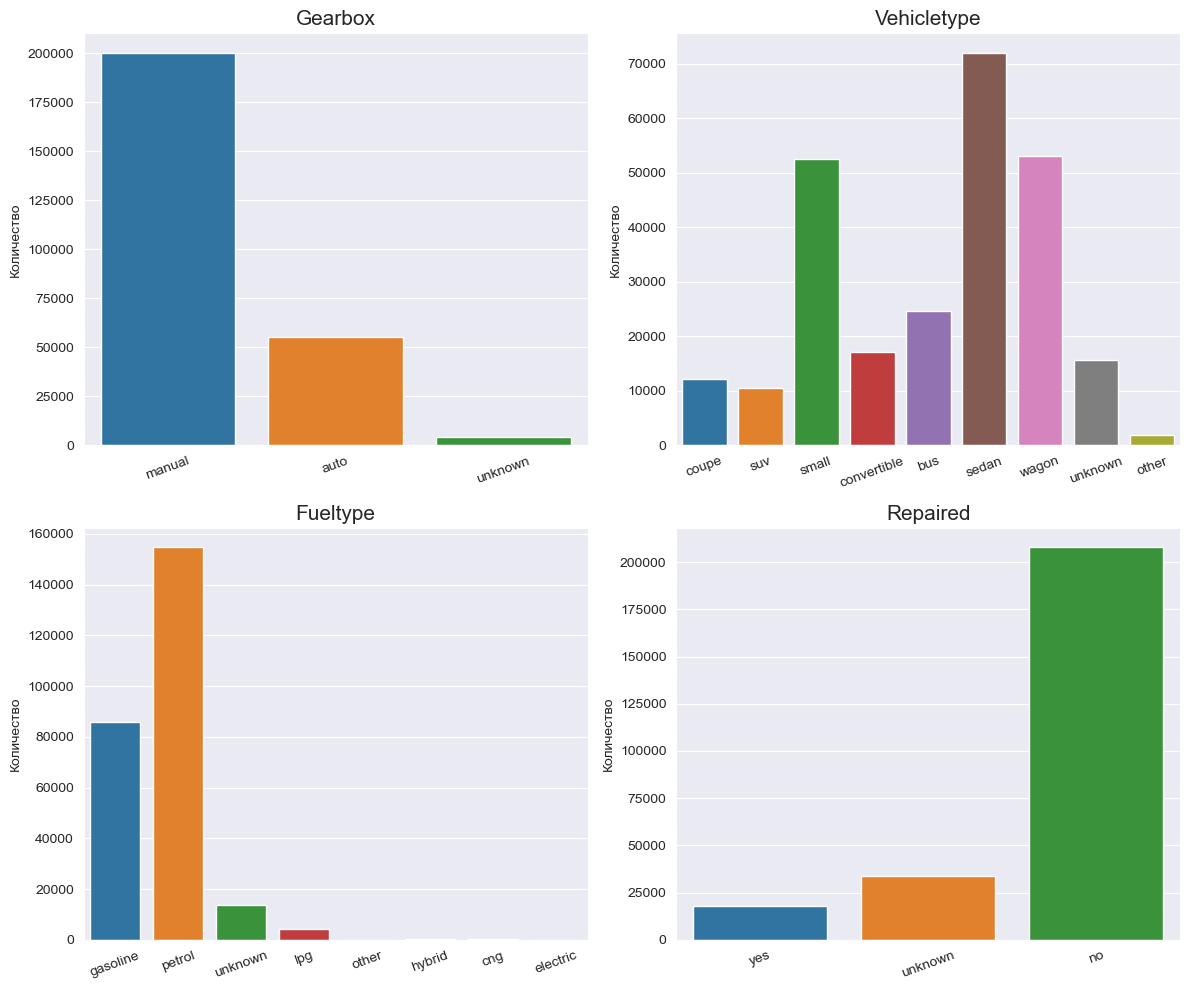

In [25]:
plt.figure(figsize=(12, 10))

for i, col in enumerate(bar_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df)
    plt.title(col.capitalize(), fontsize=15)
    plt.xlabel('')
    plt.ylabel('Количество')
    plt.xticks(rotation=20)
    
plt.tight_layout()
plt.show()

Столбец `brand` выведем отдельно для подробного разбора. Выведем только 10 наиболее популярных марок автомобилей в наших данных.

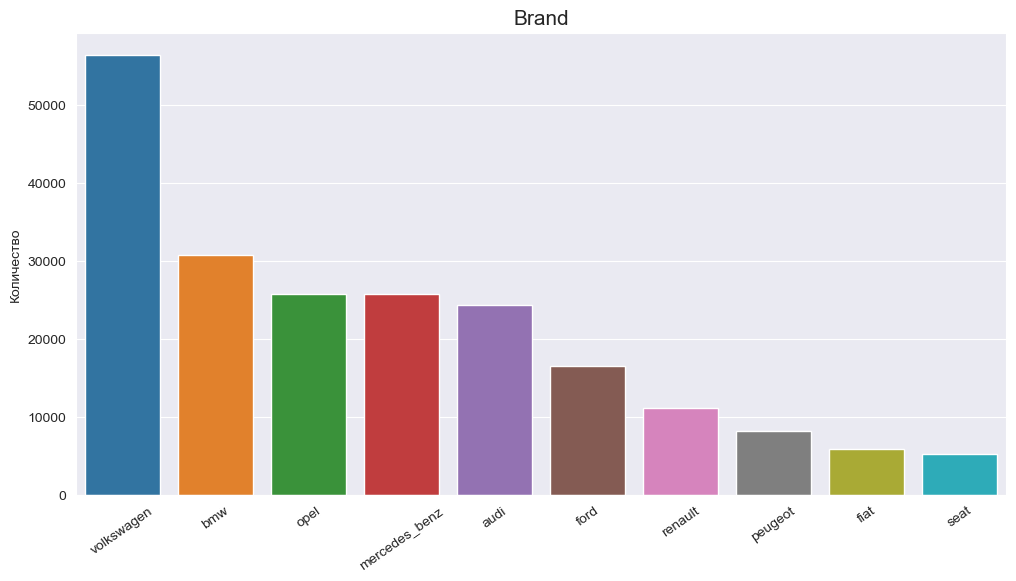

In [26]:
sns.barplot(x=df['brand'].value_counts().head(10).index, y=df['brand'].value_counts().head(10))
plt.title('Brand', fontsize=15)
plt.xlabel('')
plt.ylabel('Количество')
plt.xticks(rotation=35)
plt.show()

Вывод по диаграммам накопления:

- чаще встречаются машины с механической КП

- топ-3 типов кузова выглядят так: **sedan**, **small** и **wagon**

- чаще всего в качестве топлива используют бензин, на втором месте газ

- большая часть машин в наших данных не восстанавливались

- топ-3 марок выглядят так: **volkswagen**, **bmw** и **opel**

Проведем корреляционный анализ.

Так как в данных есть категориальные признаки, то будем использовать phik.

In [27]:
interval_cols = ['price', 'power']

In [28]:
phik_overview = phik_matrix(df, interval_cols=interval_cols) 

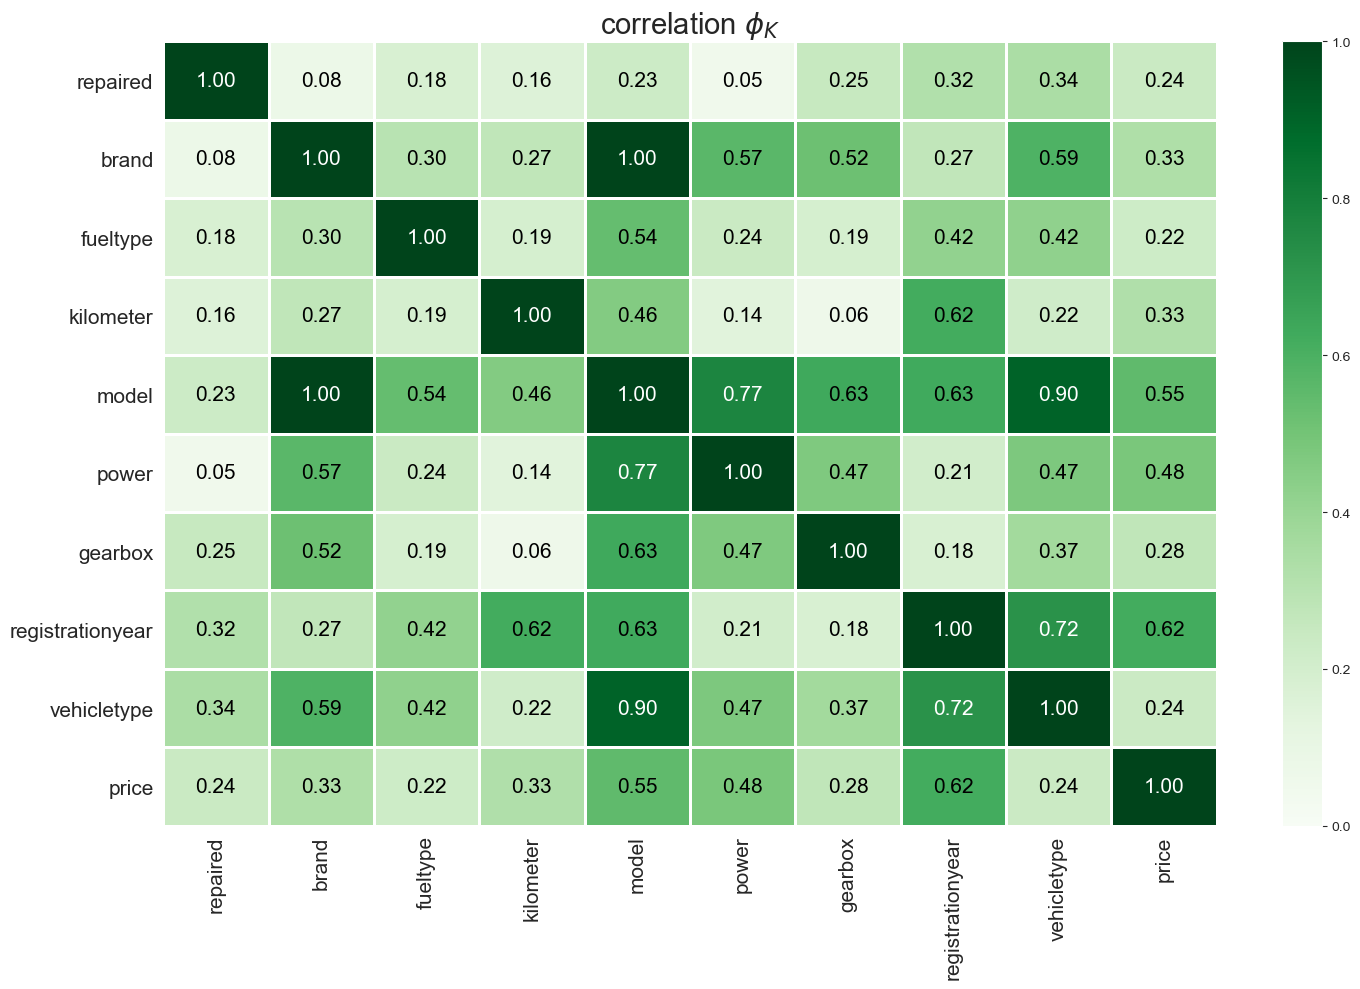

In [29]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
) 

Вывод по матрице корреляций:

- на целевой признак сильнее всего влияет количество лошадиных сил, модель и год регистрации

- самая сильная корреляция между маркой автомобиля и моделью

<div style="background-color:#D2DCFA; padding:10px;">
    
**Промежуточный вывод:**
    
Была проведена предобработка и исследовательский анализ данных.
    
 - удалены неинформативные столбцы
    
 - пропуски заполнены значением `unknown`
    
 - названия столбцов приведены к нижнему регистру
    
 - проведен анализ выбросов и подобран диапазон, при котором данные будут чище, но не потерять при этом много строк
    
Вывод по гистограммам:

- распределение цены скошено вправо, выбросов нет

- распределение лошадиных сил так же скошено вправо

- распределение пробега скошено влево. Большая часть значений сгруппированы после 140 тыс.км.

- распределение года регистрации автомобиля распределено нормально, большинство значений в диапазоне 1997-2010
    

Вывод по диаграммам накопления:

- чаще встречаются машины с механической КП

- топ-3 типов кузова выглядят так: **sedan**, **small** и **wagon**

- чаще всего в качестве топлива используют бензин, на втором месте газ

- большая часть машин в наших данных не восстанавливались

- топ-3 марок выглядят так: **volkswagen**, **bmw** и **opel**
    
    
Вывод по матрице корреляций:

- на целевой признак сильнее всего влияет количество лошадиных сил, модель и год регистрации

- самая сильная корреляция между маркой автомобиля и моделью

## Шаг 3. Подготовка данных.

Так как LightGBM и CatBoost поддерживает работу с категориальными данными, то скопируем наш датафрейм без изменений

In [30]:
df_with_cat = df.copy()

Зададим списки с категориальными и числовыми столбцами

In [31]:
cat_col = ['gearbox', 'repaired', 'vehicletype', 'model', 'fueltype', 'brand']
num_col = ['registrationyear', 'power', 'kilometer']

Разделим данные на обучающую и тестовые выборки. Сделаем это 2 раза для моделей градиентного бустинга и линейной регрессии

In [32]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

X_train.shape, X_test.shape

((194700, 9), (64900, 9))

In [33]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_train_scaled = scaler.fit_transform(X_train[num_col])
X_test_scaled = scaler.transform(X_test[num_col])

X_train_ohe = encoder.fit_transform(X_train[cat_col])
X_test_ohe = encoder.transform(X_test[cat_col])

encoder_col_names = encoder.get_feature_names_out()

X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
     
X_train = pd.concat([pd.DataFrame(X_train_scaled, columns=num_col), X_train_ohe_df], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_scaled, columns=num_col), X_test_ohe_df], axis=1)

In [34]:
X_train.shape 

(194700, 306)

Бустинг LightGBM и CatBoost работает с типом данных `category`, для этого переведем наши категориальные столбцы к нему

In [35]:
df_with_cat[cat_col] = df_with_cat[cat_col].astype('category')

In [36]:
X_1 = df_with_cat.drop('price', axis=1)
y_1 = df_with_cat['price']

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.25, random_state=RANDOM_STATE)

X_1_train.shape, X_1_test.shape

((194700, 9), (64900, 9))

In [37]:
scaler = StandardScaler()
X_1_train[num_col] = scaler.fit_transform(X_1_train[num_col])
X_1_test[num_col] = scaler.transform(X_1_test[num_col])

<div style="background-color:#D2DCFA; padding:10px;">
    
**Промежуточный вывод:**
    
Была проведена подготовка данных для моделирования:
    
- создана копия исходного датафрейма для раздельной работы с градиентным бустингом и линейной регрессией
    
- закодированы категориальные признаки
    
- стандартизированы числовые признаки
    
- данные разделены на 2 разных обучающих и тестовых выборки

## Шаг 4. Обучение моделей.

Будем использовать 3 модели для нашей задачи: Линейную регрессию, LightGBM и CatBoost

### LinearRegression

Первой для обучения будем использовать простую линейную регрессию

Соберем все данные о метриках и времени на всех этапах для удобства в анализе.

In [38]:
rmse = []
time_fit = []
time_predict = []

In [39]:
model_linear = LinearRegression()

Для оценки качества модели будем использовать кросс-валидацию

In [40]:
gs_linear = GridSearchCV(model_linear,
                         param_grid={},
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         n_jobs=-1) 

Обучим поиск по сетке на тренировочных данных

In [41]:
gs_linear.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1, param_grid={},
             scoring='neg_root_mean_squared_error')

Теперь замерим время обучения модели

In [42]:
start = time.time()
gs_linear.best_estimator_.fit(X_train, y_train)
end = time.time()
time_linear_fit = end - start

Замерим время предсказания на тренировочных данных

In [43]:
start = time.time()
gs_linear.best_estimator_.predict(X_train)
end = time.time()
time_linear_predict = end - start
print(f'RMSE for LinearRegression: {abs(gs_linear.best_score_)}')

RMSE for LinearRegression: 2316.96931964481


Сохраним все метрики

In [44]:
rmse.append(abs(gs_linear.best_score_))
time_fit.append(time_linear_fit)
time_predict.append(time_linear_predict)

### LightGBM

Теперь посмотрим какие результаты даст LightGBM

Обьявим модель и передадим список категориальных столбцов

In [45]:
model_lgbm = lgb.LGBMRegressor(verbose=-1, categorical_features=cat_col, random_state=RANDOM_STATE)

Список с параметрами для поиска по сетке

In [46]:
parameters = {
    'num_leaves': [20, 30, 35],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 200]
}

Поиск по сетке

In [47]:
gs_lgbm = GridSearchCV(model_lgbm,
                       parameters,
                       scoring='neg_root_mean_squared_error',
                       cv=3,
                       n_jobs=-1)

Обучим сетку

In [48]:
gs_lgbm.fit(X_1_train, y_1_train)

GridSearchCV(cv=3,
             estimator=LGBMRegressor(categorical_features=['gearbox',
                                                           'repaired',
                                                           'vehicletype',
                                                           'model', 'fueltype',
                                                           'brand'],
                                     random_state=42, verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'n_estimators': [100, 200],
                         'num_leaves': [20, 30, 35]},
             scoring='neg_root_mean_squared_error')

Замерим время обучения модели

In [49]:
start = time.time()
gs_lgbm.best_estimator_.fit(X_1_train, y_1_train)
end = time.time()
time_lgbm_fit = end - start

Замерим время предсказания модели на тренировочных данных

In [50]:
start = time.time()
gs_lgbm.best_estimator_.predict(X_1_train)
end = time.time()
time_lgbm_predict = end - start
print(f'RMSE for LightGBM: {abs(gs_lgbm.best_score_)}') 

RMSE for LightGBM: 1552.510907751047


Сохраним все метрики

In [51]:
rmse.append(abs(gs_lgbm.best_score_))
time_fit.append(time_lgbm_fit)
time_predict.append(time_lgbm_predict)

### CatBoost

In [52]:
model_cbsr = CatBoostRegressor(cat_features=cat_col, random_state=RANDOM_STATE, verbose=200)

In [53]:
parameters = {
    'iterations': [200, 400, 1000],
    'learning_rate': [0.1, 0.2]
}

In [54]:
gs_catboost = GridSearchCV(model_cbsr,
                           parameters,
                           scoring='neg_root_mean_squared_error',
                           cv=3,
                           n_jobs=-1) 

In [55]:
gs_catboost.fit(X_1_train, y_1_train)

0:	learn: 3991.6476358	total: 256ms	remaining: 4m 15s
200:	learn: 1605.6594891	total: 20.4s	remaining: 1m 21s
400:	learn: 1547.7455442	total: 41.7s	remaining: 1m 2s
600:	learn: 1517.2086566	total: 1m 1s	remaining: 40.8s
800:	learn: 1491.8344777	total: 1m 21s	remaining: 20.3s
999:	learn: 1473.9151788	total: 1m 41s	remaining: 0us


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000144B845A710>,
             n_jobs=-1,
             param_grid={'iterations': [200, 400, 1000],
                         'learning_rate': [0.1, 0.2]},
             scoring='neg_root_mean_squared_error')

Замерим время обучения лучшей модели на тренировочных данных

In [56]:
start = time.time()
gs_catboost.best_estimator_.fit(X_1_train, y_1_train)
end = time.time()
time_catboost_fit = end - start

0:	learn: 3991.6476358	total: 111ms	remaining: 1m 50s
200:	learn: 1605.6594891	total: 19.7s	remaining: 1m 18s
400:	learn: 1547.7455442	total: 39.3s	remaining: 58.8s
600:	learn: 1517.2086566	total: 58.2s	remaining: 38.6s
800:	learn: 1491.8344777	total: 1m 18s	remaining: 19.4s
999:	learn: 1473.9151788	total: 1m 37s	remaining: 0us


Замерим время предсказания лучшей модели на тренировочных данных

In [57]:
start = time.time()
gs_catboost.best_estimator_.predict(X_1_train)
end = time.time()
time_catboost_predict = end - start
print(f'RMSE for CatBoost: {abs(gs_catboost.best_score_)}')

RMSE for CatBoost: 1569.4580951672203


Сохраним все метрики

In [58]:
rmse.append(abs(gs_catboost.best_score_))
time_fit.append(time_catboost_fit)
time_predict.append(time_catboost_predict)

## Шаг 5. Анализ результатов

In [59]:
result = pd.DataFrame(data=[rmse, time_fit, time_predict],
                      columns=['LinearRegression', 'LightGBM', 'CatBoost'],
                      index=['RMSE', 'Learning Time', 'Predicting Time'])

In [60]:
result

,LinearRegression,LightGBM,CatBoost
RMSE,2316.969320,1552.510908,1569.458095
Learning Time,2.858643,0.887715,98.363503
Predicting Time,0.239067,0.539635,0.335075


<div style="background-color:#D2DCFA; padding:10px;">
    
# Промежуточный вывод

Было обучено три модели. Линейная регрессия и 2 модели градиентного бустинга
    
- результаты:
    
    - Лучшей оказалась модель LightGBM с минимальной метрикой - **1552** на тренировочных данных. Время обучения - **0.88** секунды
    - На втором месте CatBoost с минмальной метрикой - **1569** на тренировочных данных. Время обучения - **98** секунд
    - Самой бесполезной оказалась модель линейной регрессии. Её метрика **2316** на тренировочных данных. Время обучения **2.8** секунды
    
    - Время предсказания всех моделей в пределах 0.5 секунды
    

Исходя из результатов моделирования лучшей моделью оказалась модель градиентного бустинга - **LightGBM**. Она имеет наименьшую метрику в наших условиях. Метрика CatBoost-а остала не сильно, и если продолжать играться с гиперпараметрами (а их у него больше в разы чем у LightGBM), то можно добиться лучших результатов. Но самой большой проблемой CatBoost является время работы, и с увеличением диапазона и количества гиперпараметров значение времени будет увеличиваться непропорционально метрике качества.
    
Поэтому рекомендую выбрать для этой задачи модель градиентного бустинга **LightGBM**

## Шаг 6. Предсказание на тестовых данных

Лучшей моделью и по времени, и по значению метрики оказалась модель градиентного бустинга LightGBM, сделаем с помощью неё предсказание на тестовых данных

In [61]:
prediction = gs_lgbm.best_estimator_.predict(X_1_test)
RMSE = np.sqrt(mean_squared_error(y_1_test, prediction))
print(f'Метрика RMSE для модели LightGBM на тестовых данных: {RMSE}')

Метрика RMSE для модели LightGBM на тестовых данных: 1529.3642531315804


<div style="background-color:#D2DCFA; padding:10px;">
    
# Промежуточный вывод
    
Было выполнено предсказание на тестовых данных с помощью LightGBM. Метрика RMSE составила **1529**. Это хороший результат, который покрывает требования заказчика.

---

<div style="background-color:#D2DCFA; padding:10px;">
    
# Финальный вывод
    
---
    
Была проведена предобработка и исследовательский анализ данных.
    
 - удалены неинформативные столбцы
    
 - пропуски заполнены значением `unknown`
    
 - названия столбцов приведены к нижнему регистру
    
 - проведен анализ выбросов и подобран диапазон, при котором данные будут чище, но не потерять при этом много строк
    
Вывод по гистограммам:

- распределение цены скошено вправо, выбросов нет

- распределение лошадиных сил так же скошено вправо

- распределение пробега скошено влево. Большая часть значений сгруппированы после 140 тыс.км.

- распределение года регистрации автомобиля распределено нормально, большинство значений в диапазоне 1997-2010
    

Вывод по диаграммам накопления:

- чаще встречаются машины с механической КП

- топ-3 типов кузова выглядят так: **sedan**, **small** и **wagon**

- чаще всего в качестве топлива используют бензин, на втором месте газ

- большая часть машин в наших данных не восстанавливались

- топ-3 марок выглядят так: **volkswagen**, **bmw** и **opel**
    
    
Вывод по матрице корреляций:

- на целевой признак сильнее всего влияет количество лошадиных сил, модель и год регистрации

- самая сильная корреляция между маркой автомобиля и моделью
    
    
    
---  

    
Была проведена подготовка данных для моделирования:
    
- создана копия исходного датафрейма для раздельной работы с градиентным бустингом и линейной регрессией
    
- закодированы категориальные признаки
    
- стандартизированы числовые признаки
    
- данные разделены на 2 разных обучающих и тестовых выборки
    
    
---
    
    
Было обучено три модели. Линейная регрессия и 2 модели градиентного бустинга
    
- результаты:
    
    - Лучшей оказалась модель LightGBM с минимальной метрикой - **1552** на тренировочных данных. Время обучения - **0.4** секунд
    - На втором месте CatBoost с минмальной метрикой - **1569** на тренировочных данных. Время обучения - **101** секунда
    - Самой бесполезной оказалась модель линейной регрессии. Её метрика **2316** на тренировочных данных.
    
    - Время предсказания всех моделей в пределах 0.4 секунды
    

Исходя из результатов моделирования лучшей моделью оказалась модель градиентного бустинга - **LightGBM**. Она имеет наименьшую метрику в наших условиях. Метрика CatBoost-а остала не сильно, и если продолжать играться с гиперпараметрами (а их у него больше в разы чем у LightGBM), то можно добиться лучших результатов. Но самой большой проблемой CatBoost является время работы, и с увеличением диапазона и количества гиперпараметров значение времени будет увеличиваться непропорционально метрике качества.
    
---
    
Было выполнено предсказание на тестовых данных с помощью модели градиентного бустинга LightGBM. Метрика RMSE составила **1529**. Это хороший результат, который покрывает требования заказчика.